## ML HW2 R10921019 code

#### Import packages

In [1]:
import os
import random
import glob
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.optim import Adam
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from PIL import Image

In [2]:
!gdown 1drrS7gnyzUJPPiQcDWcHdIXqzjy2n3yZ
!unzip 'HW2.zip'

串流輸出內容已截斷至最後 5000 行。
 extracting: data/train/35561.jpg    
 extracting: data/train/25855.jpg    
 extracting: data/train/19327.jpg    
 extracting: data/train/26948.jpg    
 extracting: data/train/11690.jpg    
 extracting: data/train/16673.jpg    
 extracting: data/train/11974.jpg    
 extracting: data/train/29951.jpg    
 extracting: data/train/19225.jpg    
 extracting: data/train/16735.jpg    
 extracting: data/train/29258.jpg    
 extracting: data/train/34324.jpg    
 extracting: data/train/23429.jpg    
 extracting: data/train/32778.jpg    
 extracting: data/train/18948.jpg    
 extracting: data/train/16266.jpg    
 extracting: data/train/32922.jpg    
 extracting: data/train/19090.jpg    
 extracting: data/train/11971.jpg    
 extracting: data/train/32888.jpg    
 extracting: data/train/23236.jpg    
 extracting: data/train/10155.jpg    
 extracting: data/train/26199.jpg    
 extracting: data/train/28311.jpg    
 extracting: data/train/18732.jpg    
 extracting: data/train/12197

#### Set arguments and random seed

In [3]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'
DEVICE_ID = 0
SEED = 5566
NUM_ECPOCH = 50

torch.cuda.set_device(DEVICE_ID)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### Process data

In [4]:
def load_train_data(img_path, label_path, valid_ratio=0.12):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'{img_path}/{i+10000}.jpg' for i in range(len(train_label)-1)]
    
    train_data = list(zip(train_image, train_label))
    random.shuffle(train_data)
    
    split_len = int(len(train_data) * valid_ratio)
    train_set = train_data[split_len:]
    valid_set = train_data[:split_len]
    
    return train_set, valid_set

def load_test_data(img_path):
    test_set = [f'{img_path}/{i}.jpg' for i in range(7000, 10000)]
    return test_set
    
def compute_statistics(dataset):
    data = []
    for (img_path, label) in dataset:
        data.append(np.array(Image.open(img_path)))
    data = np.array(data)
    return data.mean(), data.std()

In [82]:
train_set, valid_set = load_train_data(TRA_PATH, LABEL_PATH)
test_set = load_test_data(TST_PATH)
#transform = None # do augmentation there


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.450], [0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.450], [0.225])
])

In [87]:
count_list=[0,0,0,0,0,0,0]
for i in range(len(train_set)):
  count_list[int(train_set[i][1])]+=1
print(count_list)

[3174, 342, 3216, 5750, 3818, 2541, 3939]


#### Customize dataset

In [100]:
class FaceExpressionDataset(Dataset):
    def __init__(self, data,transform=train_transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    
    def read_img(self, idx):
        img = Image.open(self.data[idx][0])
        if self.transform:
          img = self.transform(img)
        return img
    
    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.data[idx][1]
        return img, label
    
class TestingDataset(Dataset):
    def __init__(self, data,transform=test_transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def read_img(self, idx):
        img = Image.open(self.data[idx])
        # if not self.augment is None:
        #     img = self.augment(img)
        if self.transform:
            img = self.transform(img)
        #img = torch.from_numpy(np.array(img)).float()
        #img = img.unsqueeze(0).float()
        # img = self.normalize(img)
        return img, self.data[idx].split('/')[-1][:-4]
        
    def __getitem__(self, idx):
        img, name = self.read_img(idx)
        
        return img, name

In [105]:
train_dataset = FaceExpressionDataset(train_set)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = FaceExpressionDataset(valid_set)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = TestingDataset(test_set)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)                  

#### Define module class

In [9]:
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super(FaceExpressionNet, self).__init__()
        # TODO
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),
            nn.MaxPool2d((3, 2)),
            #nn.Dropout(0.1),
            ##
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),
            #nn.Dropout(0.1),
            ##
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            ##
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(256, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),
            ##
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),
            ##
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),
            nn.MaxPool2d((2, 2)),
            ##
            nn.Conv2d(256, 256,kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.05),
            nn.AdaptiveAvgPool2d((1,1)),
            #nn.Dropout(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 7),
            #nn.Dropout(0.2),
        )

    def forward(self, x):
        #image size (64,64)
        x = self.conv(x) #(32,32)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

#### Define training and testing process

In [10]:
def train(train_loader, model, loss_fn, use_gpu=True):
    model.train()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        if use_gpu:
            img = img.to(device)
            label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()            
        optimizer.step()
        with torch.no_grad():
            predict = torch.argmax(output, dim=-1)
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
    print("Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
    return train_acc, train_loss
    
def valid(valid_loader, model, loss_fn, use_gpu=True):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for idx, (img, label) in enumerate(valid_loader):
            if use_gpu:
                img = img.to(device)
                label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc
       
        valid_acc = np.mean(valid_acc)
        valid_loss = np.mean(valid_loss)
        print("Epoch: {}, valid Loss: {:.4f}, valid Acc: {:.4f}".format(epoch + 1, valid_loss, valid_acc))
    return valid_acc, valid_loss 

def save_checkpoint(valid_acc, acc_record, epoch, prefix='model'):
    # you can define the condition to save model :)
    if valid_acc >= np.mean(acc_record[-5:]):    
        checkpoint_path = f'{prefix}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print('model saved to %s' % checkpoint_path)

def better(acc_record):
    if max(acc_record) == acc_record[-1]: return True
    return False

In [11]:
if __name__ == '__main__':
    model = FaceExpressionNet()
    if use_gpu:
        model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    acc_record = []
    train_loss_record = []
    valid_loss_record = []
    iter=[]
    break_count = 0;
    for epoch in range(NUM_ECPOCH):
        train_acc, train_loss = train(train_loader, model, loss_fn, use_gpu)
        valid_acc, valid_loss = valid(valid_loader, model, loss_fn, use_gpu=True)
        acc_record.append(valid_acc)
        train_loss_record.append(train_loss)
        valid_loss_record.append(valid_loss)
        iter.append(epoch)
        if better(acc_record):
            break_count =0
            save_checkpoint(valid_acc, acc_record, epoch, prefix='model')
        else: 
          break_count +=1
        if break_count == 5:
          print('waste time!!')
          break
        print('########################################################')

Epoch: 1, train Loss: 1.7678, train Acc: 0.2804
Epoch: 1, valid Loss: 1.9771, valid Acc: 0.2672
model saved to model.pth
########################################################
Epoch: 2, train Loss: 1.5245, train Acc: 0.4081
Epoch: 2, valid Loss: 1.5308, valid Acc: 0.4066
model saved to model.pth
########################################################
Epoch: 3, train Loss: 1.3965, train Acc: 0.4591
Epoch: 3, valid Loss: 1.5341, valid Acc: 0.4050
########################################################
Epoch: 4, train Loss: 1.3187, train Acc: 0.4929
Epoch: 4, valid Loss: 1.4931, valid Acc: 0.4327
model saved to model.pth
########################################################
Epoch: 5, train Loss: 1.2661, train Acc: 0.5148
Epoch: 5, valid Loss: 1.3838, valid Acc: 0.4804
model saved to model.pth
########################################################
Epoch: 6, train Loss: 1.2262, train Acc: 0.5283
Epoch: 6, valid Loss: 1.2039, valid Acc: 0.5306
model saved to model.pth
##############

In [101]:
def test(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_result = []
        predict_name = []
        for img, name in test_loader:
            if use_gpu:
                img = img.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1).tolist()
            predict_result += predict
            predict_name += name
        
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in zip(predict_name, predict_result):
            writer.writerow([id, r])

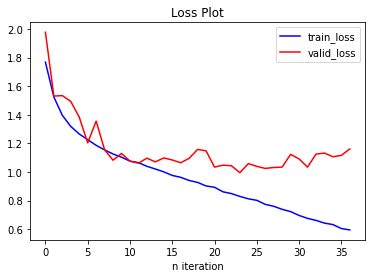

In [91]:
train_loss_record = np.array(train_loss_record)
valid_loss_record = np.array(valid_loss_record)
#train_loss_record = train_loss_record.mean(1)
##plot loss curve
title = 'Loss Plot'
plt.plot(iter, train_loss_record, '-b', label='train_loss')
plt.plot(iter, valid_loss_record, '-r', label='valid_loss')
plt.xlabel("n iteration")
plt.legend(loc='upper right')
plt.title(title)
plt.show()

In [102]:
del model
model = FaceExpressionNet()
model.load_state_dict(torch.load('model_final.pth'))
model = model.cuda()
test(test_loader, model)


In [103]:
def eval_report(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_list = []
        label_list = []
        error_img =[]
        for idx, (img, label) in enumerate(valid_loader):
            if use_gpu:
                img = img.to(device)
                label = label.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1)
            label_list=label_list+(label.cpu().tolist())
            predict_list=predict_list+(predict.cpu().tolist())
            for i in range(len(label)):
              if label[i]==1 and predict[i]==0:
                error_img = img[i].cpu().numpy() 
            
    return label_list, predict_list,error_img



In [106]:

label, predict, error_img = eval_report(test_loader, model)

[[[-2. -2. -2. ... -2. -2. -2.]
  [-2. -2. -2. ... -2. -2. -2.]
  [-2. -2. -2. ... -2. -2. -2.]
  ...
  [-2. -2. -2. ... -2. -2. -2.]
  [-2. -2. -2. ... -2. -2. -2.]
  [-2. -2. -2. ... -2. -2. -2.]]]


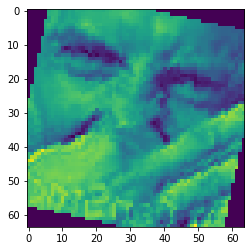

In [109]:
print(error_img)
plt.imshow(error_img.squeeze())

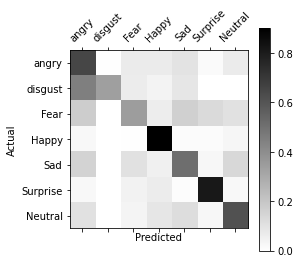

In [48]:
###參考https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix?fbclid=IwAR2M2teNS0fqRha1ttfYNJL8LixoOVNeuiwCz7CMxqtcQoZy0B_kfzf3mIA
import matplotlib.pyplot as plt
import pandas as pd
y_actu = pd.Series(label, name='Actual')
y_pred = pd.Series(predict, name='Predicted')

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
  plt.matshow(df_confusion, cmap=cmap) # imshow
  #plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, ["angry","disgust","Fear","Happy","Sad","Surprise","Neutral"], rotation=45)
  plt.yticks(tick_marks, ["angry","disgust","Fear","Happy","Sad","Surprise","Neutral"])
  #plt.tight_layout()
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)
  #plt.xlabel(["angry","disgust","Fear","Happy","Sad","Surprise","Neutral"])
  #plt.ylabel(["angry","disgust","Fear","Happy","Sad","Surprise","Neutral"])

df_confusion = pd.crosstab(y_actu, y_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")
plot_confusion_matrix(df_conf_norm)



Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64', name='Actual')